In [9]:
### Follow https://nthu-datalab.github.io/ml/labs/13_Sentiment_Analysis_and_Neural_Machine_Translation/13_Sentiment_Analysis_and_Neural_Machine_Translation.html
# It contains two topic about RNN (two examples)
# 1. Sentiment Analysis
# 2. Neural Machine Translation

In [10]:
import numpy as np
import tensorflow as tf
import os

In [11]:
def read_file(directory):
    data = []
    for f in os.listdir(directory)[:1000]:
        content = open(directory + f, 'r', encoding='utf8').read()
        data.append((content, int(f[-5]) > 5))
    return data

train_data = read_file('../../dataset/aclImdb/train/neg/') + read_file('../../dataset/aclImdb/train/pos/')
test_data = read_file('../../dataset/aclImdb/test/neg/') + read_file('../../dataset/aclImdb/test/pos/')

In [12]:
len(train_data)

2000

In [13]:
import spacy

# nlp = spacy.load('en')
nlp = spacy.load('en_core_web_lg')

w_apple = nlp('apple')
w_banana = nlp('banana')
w_mac = nlp('mac')

print("%s vs %s: %.6f" % (w_apple, w_banana, w_apple.similarity(w_banana)))
print("%s vs %s: %.6f" % (w_apple, w_mac, w_apple.similarity(w_mac)))
print("%s vs %s: %.6f" % (w_banana, w_mac, w_banana.similarity(w_mac)))
# Do not know why

apple vs banana: 0.583184
apple vs mac: 0.574916
banana vs mac: 0.243292


In [14]:
def remove_unknown_words(data):
    new_data = []
    for content, label in data:
        s = ' '.join([w for w in content.split(' ') if w in nlp.vocab])
        new_data.append((s, label))
    return new_data

train_dat = remove_unknown_words(train_data)
test_dat = remove_unknown_words(test_data)

In [15]:
# 避免 padding 太多導致學不到東西，先將 data 分類
class BatchGenerator:
    def __init__(self, dat, batch_size):
        n = len(dat)
        n_batch = n // batch_size + 1
        self.batch_xs, self.batch_ys, self.reviews = [], [], []
        padding_vec = nlp(' ').vector

        dat = sorted(map(lambda pair: (nlp(pair[0]), pair[1]), dat), key=lambda x: len(x[0]))
        for i in range(n_batch):
            print("第 {}/{} 個 batch".format(i+1, n_batch))
            
            batch_dat = dat[i*batch_size : (i+1)*batch_size]
            if not batch_dat: continue
            
            longest = len(batch_dat[-1][0])            
            batch_x = np.zeros((batch_size, longest, 300))
            batch_y = np.zeros((batch_size, 2))    # label for 0,1 # 0 - 9
            review  = []
            
            for j, each in enumerate(batch_dat):
                for k, w in enumerate(each[0]):
                    batch_x[j][k] = w.vector        # use existing Word2vec model
                for k in range(k, longest):
                    batch_x[j][k] = padding_vec     # padding with ' '

                batch_y[j][each[1]] = 1             # represent class as one-hot encoding
                review.append(each[0])
            
            self.batch_xs.append(batch_x)
            self.batch_ys.append(batch_y)
            self.reviews.append(review)
        
    def get(self, batch_id):
        # print(len(self.batch_xs))
        return self.batch_xs[batch_id], self.batch_ys[batch_id], self.reviews[batch_id]

In [8]:
batch = BatchGenerator(train_dat, 128)

xs, ys, rv = batch.get(0)
print(xs[0])
print(ys[0])
print(rv[0])

KeyboardInterrupt: 

In [23]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

class SentimentReviewRNN:

    def __init__(self):
        with tf.variable_scope('rnn_i/o'):
            # use None for batch size and dynamic sequence length
            self.inputs = tf.placeholder(tf.float32, shape=[None, None, 300])
            self.groundtruths = tf.placeholder(tf.float32, shape=[None, 2])

        with tf.variable_scope('rnn_cell'):
            self.cell = tf.contrib.rnn.LSTMCell(128)
            # project RNN output into target class dimension
            self.out_cell = tf.contrib.rnn.OutputProjectionWrapper(self.cell, 2)

        with tf.variable_scope('rnn_forward'):
            # use dynamic_rnn for different length
            self.outputs, _ = tf.nn.dynamic_rnn(self.out_cell, self.inputs, dtype=tf.float32)
            self.outputs = self.outputs[:, -1, :]  # only use the last output of sequence

        with tf.variable_scope('rnn_loss'):
            # use cross_entropy as class loss
            self.loss = tf.losses.softmax_cross_entropy(onehot_labels=self.groundtruths, logits=self.outputs)
            self.optimizer = tf.train.AdamOptimizer(0.1).minimize(self.loss)

        with tf.variable_scope('rnn_accuracy'):
            self.accuracy = tf.contrib.metrics.accuracy(labels=tf.argmax(self.groundtruths, axis=1), 
                                                        predictions=tf.argmax(self.outputs, axis=1))

        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())  # don't forget to initial all variables
        self.saver = tf.train.Saver()  # a saver is for saving or restoring your trained weight

    def train(self, batch_x, batch_y):
        fd = {}
        fd[self.inputs] = batch_x
        fd[self.groundtruths] = batch_y
        # feed in input and groundtruth to get loss and update the weight via Adam optimizer
        loss, accuracy, _ = self.sess.run([self.loss, self.accuracy, self.optimizer], fd)

        return loss, accuracy

    def test(self, batch_x, batch_y):
        fd = {}
        fd[self.inputs] = batch_x
        fd[self.groundtruths] = batch_y
        prediction, accuracy = self.sess.run([self.outputs, self.accuracy], fd)

        return prediction, accuracy

    def save(self, e):
        self.saver.save(self.sess, 'model/rnn/rnn_%d.ckpt' % (e + 1))

    def restore(self, e):
        self.saver.restore(self.sess, 'model/rnn/rnn_%d.ckpt' % (e))

In [17]:
# hyperparameter of our network
EPOCHS = 30
BATCH_SIZE = 256
train_batch = BatchGenerator(train_dat, BATCH_SIZE)
test_batch = BatchGenerator(test_dat, BATCH_SIZE)

第 1/8 個 batch
第 2/8 個 batch
第 3/8 個 batch
第 4/8 個 batch
第 5/8 個 batch
第 6/8 個 batch
第 7/8 個 batch
第 8/8 個 batch
第 1/8 個 batch
第 2/8 個 batch
第 3/8 個 batch
第 4/8 個 batch
第 5/8 個 batch
第 6/8 個 batch
第 7/8 個 batch
第 8/8 個 batch


In [24]:
n_train = len(train_dat) // BATCH_SIZE
n_test = len(test_dat) // BATCH_SIZE
tf.reset_default_graph()
model = SentimentReviewRNN()

In [25]:
rec_loss = []

for e in range(EPOCHS):  # train for several epochs
    loss_train = 0
    accuracy_train = 0

    for b in range(n_train):  # feed batches one by one
        batch_x, batch_y, _ = train_batch.get(b)
        loss_batch, accuracy_batch = model.train(batch_x, batch_y)

        loss_train += loss_batch
        accuracy_train += accuracy_batch

    loss_train /= n_train
    accuracy_train /= n_train

#     model.save(e)  # save your model after each epoch
    rec_loss.append([loss_train, accuracy_train])

# np.save('./model/rnn/rec_loss.npy', rec_loss)

1.1902387355055128


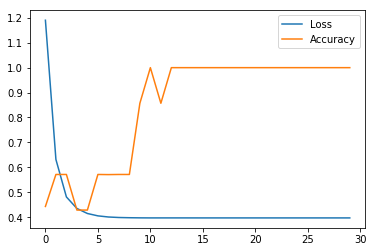

In [26]:
# rec_loss = np.load('./model/rnn/rec_loss.npy')

import matplotlib.pyplot as plt

print(rec_loss[0][0])
plt_loss = plt.plot([rec_loss[i][0] for i in range(len(rec_loss))])
plt_accuracy = plt.plot([rec_loss[i][1] for i in range(len(rec_loss))])
plt.legend(['Loss', 'Accuracy'])
plt.show()

In [27]:
accuracy_test = 0

for b in range(n_test):
    batch_x, batch_y, _ = test_batch.get(b)
    _, accuracy_batch = model.test(batch_x, batch_y)

    accuracy_test += accuracy_batch

accuracy_test /= n_test

print('Test: %.4f' % (accuracy_test))

Test: 1.0000


In [27]:
%reset -sf